In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Поработаем с таким актером как Киану Ривз, он добряк, и вряд ли обидится на то, что мы измываеся над его фотографией, приделывая к ней солнцезащитные очки:)

P.S. Далее каждый пункт задачи будет оформляться как отдельная функция, чтобы не объявлять одни и те же переменные по несколько раз, и выводить результат каждого пункта одним отдельным вызовом.

In [ ]:
image_path = 'reeves.jpg'
sunglasses_path = 'sgs3.png'

## Пункты 1-2

Так как задание по сверточным нейронным сетям уже пройдено, текущая задача требует работы только с одним изображением, которое мы к тому же выбираем сами, то и использовать что-то крутое и тяжелое для детектирования лиц смысла нет.Поэтому можно вернуться к истокам и использовать алгоритмы, применявшиеся в первых детекторах лиц в реальном времени, а именно каскады Хаара - дешево и сердито, даже не надо умолять Google выделить GPU:)

In [ ]:
def detect_and_highlight_face(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    if len(faces) == 0:
      print("are you sure?")
      exit(1)

    (x, y, w, h) = faces[0]
    center = (x + w//2, y + h//2)
    axes = (w//2, h//2)
    angle = 0
    color = (255, 0, 0)
    cv2.ellipse(img, center, axes, angle, 0, 360, color, 5)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

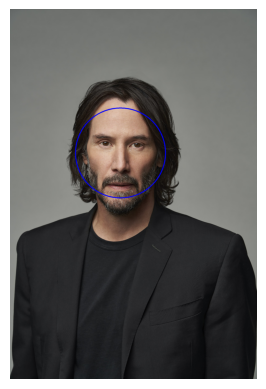

In [ ]:
detect_and_highlight_face(image_path)

## Пункт 3

### Сначала детектируем глаза и выделим их на изображении

Для детектирования глаз можно также использовать каскады Хаара

In [ ]:
def detect_and_highlight_faces_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    if len(faces) == 0:
      print("are you sure?")
      exit(1)

    (x, y, w, h) = faces[0]

    # Здесь и далее ROI - the region of interest
    roi_gray = gray[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)

    for (ex, ey, ew, eh) in eyes:
        center_eye = (x + ex + ew//2, y + ey + eh//2)
        axes_eye = (ew//2, eh//2)
        angle_eye = 0
        color_eye = (0, 255, 0)
        cv2.ellipse(img, center_eye, axes_eye, angle_eye, 0, 360, color_eye, 5)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

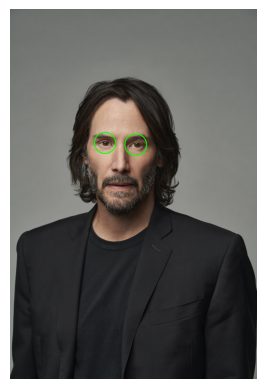

In [ ]:
detect_and_highlight_faces_eyes(image_path)

Теперь защитим Джона Уика от солнца, надев на него очки.

Прежде, чем переходить к обработке изображения, необходимо определить понятие наслоения изображения или блендинга, поэтому введем еще одну функцию для непосредственно реализации данного алгоритма. Для ясности все подробности оставил в комментариях к функции

In [ ]:
def overlay_image(background, overlay, x, y):
    """
    Функция, реализующая наслоение двух изображений
    :background - исходное изображени
    :overlay - изображение, которое будем накладывать
    :x - координата x, в которую помещаем overlay
    :y - координата y, в которую помещаем overlay
    """
    # Нормализуем канал прозрачности, чтобы значения были от 0 до 1
    alpha_channel = overlay[:, :, 3] / 255.0
    # Соотносим размерности изображений
    alpha_channel = np.stack([alpha_channel] * 3, axis=-1)

    # Высчитываем регион, в котором будет происходить "блендинг" (смешивание)
    background_region = (1.0 - alpha_channel) * background[y:y+overlay.shape[0], x:x+overlay.shape[1], :3]
    overlay_region = alpha_channel[:, :, :3] * overlay[:, :, :3]

    # Соединяем эти 2 региона
    background[y:y+overlay.shape[0], x:x+overlay.shape[1], :3] = background_region + overlay_region

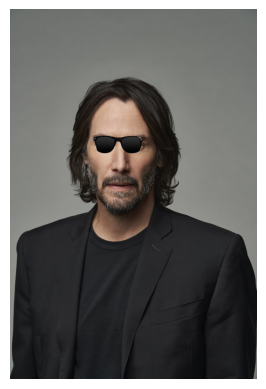

In [ ]:
def detect_and_replace_eyes_with_sunglasses(image_path, sunglasses_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    # Добавили параметр cv2.IMREAD_UNCHANGED, чтобы загрузить измерение с прозрачностью
    sunglasses = cv2.imread(sunglasses_path, cv2.IMREAD_UNCHANGED)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    if len(faces) == 0:
      print("are you sure?")
      exit(1)
    x, y, w, h = faces[0]

    roi_gray = gray[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)

    if len(eyes) == 2:
        # Глаза иногда детектируются не слева направо, а наоборот
        # поэтому для надежности отслеживаем этот момент
        (exl, eyl, ewl, ehl), (exr, eyr, ewr, ehr) = eyes
        ex1, ex2 = (exl, exr) if exl < exr else (exr, exl)
        ey1, ey2 = (eyl, eyr) if exl < exr else (eyr, eyl)
        ew1, ew2 = (ewl, ewr) if exl < exr else (ewr, ewl)
        eh1, eh2 = (ehl, ehr) if exl < exr else (ehr, ehl)
        eye_center1 = (x + ex1 + ew1//2, y + ey1 + eh1//2)
        eye_center2 = (x + ex2 + ew2//2, y + ey2 + eh2//2)

        # Можно считать дистанцию между глазами как расстояние между серединами или краями,
        # но на практике логично, что очки будут выходить за эти пределы и покрывать
        # лицо еще немного, поэтому неплохо бы взять зазор, допустим в 10-15% от расстояния
        # между краем прямоугольника, где определено лицо и краем прямоугольника,
        # где определен глаз
        gap1 = ex1 * 0.15
        gap2 = (w - ex2 - ew2) * 0.15
        eyes_distance = np.sqrt((ex2+ew2+gap2-ex1-gap1)**2 - (ey2-ey1)**2)

        # Масштабируем изображение очков
        scale_factor = eyes_distance / sunglasses.shape[1]
        sunglasses_resized = cv2.resize(sunglasses, (int(sunglasses.shape[1] * scale_factor), int(sunglasses.shape[0] * scale_factor)))

        # Определяем координаты местоположния очков
        x_sunglasses = int(x + ex1 - gap1)
        y_sunglasses = (ey1 if ey1 < ey2 else ey2) + y

        overlay_image(img, sunglasses_resized, x_sunglasses, y_sunglasses)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

detect_and_replace_eyes_with_sunglasses(image_path, sunglasses_path)

## Пункт 4

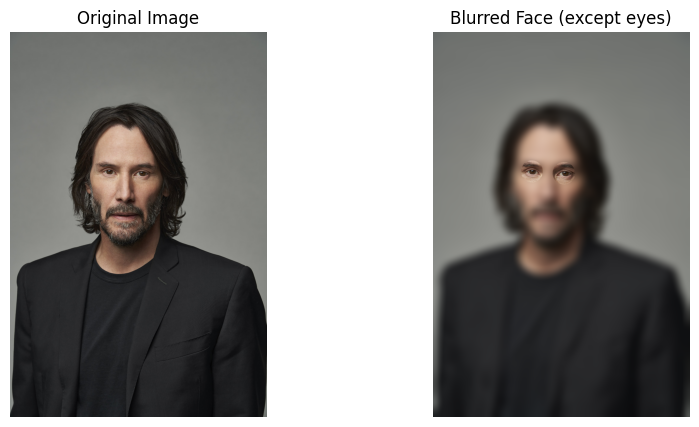

In [ ]:
def blur_face_except_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Сразу создадим маску для определения региона размытия (с исключением глаз)
    mask = np.zeros_like(gray)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    if len(faces) == 0:
      print("are you sure?")
      exit(1)
    x, y, w, h = faces[0]

    roi_gray = gray[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)

    # Исключем глаза
    for (ex, ey, ew, eh) in eyes:
        eye_center = (x + ex + ew // 2, y + ey + eh // 2)
        radius = min(ew, eh) // 2
        cv2.circle(mask, eye_center, radius, 255, -1)

    # Размываем лицо
    blurred_face = cv2.GaussianBlur(img, (99, 99), 30)
    result = np.where(mask[:, :, np.newaxis] == 0, blurred_face, img)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('Blurred Face (except eyes)')
    plt.axis('off')

    plt.show()

blur_face_except_eyes(image_path)